In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,9)

pd.set_option('display.max_columns', None)

df = pd.read_csv('TOP500_all.csv', low_memory=False, parse_dates={'Date': ['Year','Month','Day']})
df.set_index(["Date", "Rank"], inplace=True)
df = df[sorted(df.columns)]

In [2]:
df.columns

Index(['Accelerator', 'Accelerator Cores', 'Accelerator/Co-Processor',
       'Application Area', 'Architecture', 'Computer', 'Continent', 'Country',
       'CountryISO', 'Efficiency (%)', 'First Appearance', 'First Rank',
       'HPCG [TFlop/s]', 'ISA', 'Interconnect', 'Interconnect Family',
       'Manufacturer', 'Measured Size', 'Memory', 'Mflops/Watt', 'Name',
       'Nhalf', 'Nmax', 'OS Family', 'Operating System', 'Power', 'Power (kW)',
       'Power Efficiency [GFlops/Watts]', 'Power Source', 'Previous Rank',
       'Processor', 'Processor Cores', 'Processor Family',
       'Processor Generation', 'Processor Speed (MHz)', 'Processor Technology',
       'Processors', 'RMax', 'RPeak', 'Region', 'Rmax [TFlop/s]',
       'Rpeak [TFlop/s]', 'Segment', 'Site', 'Site ID', 'System Family',
       'System ID', 'System Model', 'Total Cores', 'Vendor'],
      dtype='object')

## Column explanation

- **Accelerator** : GPU cards, e.g. : 'NVIDIA 2050' 'IBM PowerXCell 8i' 'NVIDIA 2070' 'ATI GPU', 'NVIDIA 2090'.
    <u> TODO : rename as accelerator name </u>
- **Accelerator Cores** : Total cluster # gpu cores. Coupled with accelerator column. 
- **Accelerator/Co-Processor** : Same as accelerator column. <u>TODO: move to accelerator. </u>
- **Architecture** : SMP, MPP, Unique Cluster
- **Application Area** :  Weather, Chemistry, Gaming, Retail, etc. Available June 1993 - June 2011. 
    + <u>We might use site and name to complete.</u>
- **Computer**: Type of computer. Very messy and unexploitable column : Lenovo C1040, Xeon E5-2673v4 20C 2.3GHz, 40G Ethernet, ORIGIN 2000 .
- **HPCG** (high performance conjugate gradient) benchmark. It is intended to model the data access patterns of real-world applications such as sparse matrix calculations, testing the effect of limitations of the memory subsystem and internal interconnect of the supercomputer on its computing performance.
- **ISA** : Instruction Set Architecture : x86-64, POWER, MIPS, Sparc
- **Manufacturer** : IBM, Hewlett-Packard, Cray Inc, SGI, Lenovo... 
- **Measured Size** : Inconsistent data. <u> TODO : drop</u>
- **Nmax** : the size of the largest problem run on a machine.
- **Nhalf** :the size where half the Rmax execution rate is achieved.
- **Processor Cores** : Number of cores / processor. E.g. 6,  9,  4,  2, 12,
- **Processors** : Total cluster # processors,  recorded between June 1993 - June 2008. 
    + <u>TODO: compile into total cores</u>
- **Processor** :  Processor name, consistent across all the dataset. 
    + <u>TODO: rename to processor name</u>
- **Processor Speed (MHz)** : Consisten acroos the dataset.
- **Region** : Zones of continents, e.g. Western Europe, North America
- **Rpeak** : LINPACK benchmark on _GFlops/s_. The theoretical peak performance GFLOPS for the machine.  1993-06-01 to 2016-11-01 . 
    + <u>TODO: translate in TFlops</u>
- **Rmax** : LINPACK benchmark  on _GFlops/s_. The performance the largest problem run on the machine. 1993-06-01 to 2016-11-01.
     + <u>TODO: translate in TFlops</u>
- **Segment** : ['Research' 'Industry' 'Academic' 'Classified' 'Vendor' 'Government', 'Others'], recorded across dataset.
- **Site** : Place where the cluster has been deployed. Sometimes provides a clear place, sometimes it provides the nature of the client, e.g. : Government, Software Company, Service Provider, New York City - Department of Finance.
- **System Family** : Manufacturer server cluster generation.
- **System Model** : Manufacturer server cluster model. Closely related to system family.
- **Total Cores** : Total cluster # cores. Starts on Nov 2008 when process architectures start to set multiple cores on one processor.

In [2]:
# XXX make sure two columns are fully complementary categorical and numerical data.

def col_info(coln):
    col = df[coln]
    print("\n----", coln, "----")
    print("Unique", col.value_counts())
    print("Description", col.describe())
    
    
    print("First appearance: ", col.first_valid_index())
    print("Last appearance: ", col.last_valid_index()) 
    


col_info("Accelerator/Co-Processor")
col_info("Accelerator")


---- Accelerator/Co-Processor ----
Unique None                                7249
NVIDIA Tesla V100                    359
NVIDIA Tesla P100                    278
NVIDIA 2090                          126
NVIDIA Tesla K40                     110
                                    ... 
Intel MIC                              1
PEZY-SC2                               1
NDIVA M2090/Intel Xeon Phi 7120P       1
NVIDIA Tesla GP100                     1
MN-Core                                1
Name: Accelerator/Co-Processor, Length: 63, dtype: int64
Description count     9000
unique      63
top       None
freq      7249
Name: Accelerator/Co-Processor, dtype: object
First appearance:  (Timestamp('2012-06-01 00:00:00'), 1.0)
Last appearance:  (Timestamp('2020-11-01 00:00:00'), 500.0)

---- Accelerator ----
Unique None                 942
NVIDIA 2090           18
NVIDIA 2050           17
NVIDIA 2070           12
IBM PowerXCell 8i      7
ATI GPU                4
Name: Accelerator, dtype: int64


# Renaming and aggregating columns

## Merge acceleration data into Accelerator Name

In [3]:
mapToNa = lambda x: np.nan if x == 'None' or x == None else x

# Make consistent use of NaN
df['Accelerator/Co-Processor'] = df['Accelerator/Co-Processor'].map(mapToNa)
df['Accelerator'] = df['Accelerator'].map(mapToNa)


In [4]:
df['Accelerator Name'] = df['Accelerator/Co-Processor'].where( df['Accelerator/Co-Processor'].notnull(), df['Accelerator'])

In [5]:
df[['Accelerator Name', 'Accelerator/Co-Processor', 'Accelerator']][df['Accelerator'].notnull()]

Accelerator Name Accelerator/Co-Processor  \
Date       Rank                                                
2011-06-01 2.0          NVIDIA 2050                      NaN   
           4.0          NVIDIA 2050                      NaN   
           5.0          NVIDIA 2050                      NaN   
           10.0   IBM PowerXCell 8i                      NaN   
           13.0         NVIDIA 2070                      NaN   
           22.0             ATI GPU                      NaN   
           33.0         NVIDIA 2050                      NaN   
           54.0         NVIDIA 2070                      NaN   
           61.0   IBM PowerXCell 8i                      NaN   
           86.0         NVIDIA 2050                      NaN   
           126.0        NVIDIA 2050                      NaN   
           148.0        NVIDIA 2070                      NaN   
           169.0        NVIDIA 2070                      NaN   
           274.0        NVIDIA 2050                      NaN   
           388.0        NVIDIA 2070                      NaN   
           406.0  IBM PowerXCell 8i                      NaN   
           407.0  IBM PowerXCell 8i                      NaN   
           408.0  IBM PowerXCell 8i                      NaN   
           430.0            ATI GPU                      NaN   
2011-11-01 2.0          NVIDIA 2050                      NaN   
           4.0          NVIDIA 2050                      NaN   
           5.0          NVIDIA 2050                      NaN   
           10.0   IBM PowerXCell 8i                      NaN   
           16.0         NVIDIA 2050                      NaN   
           18.0         NVIDIA 2070                      NaN   
           21.0         NVIDIA 2050                      NaN   
           33.0             ATI GPU                      NaN   
           75.0         NVIDIA 2090                      NaN   
           82.0         NVIDIA 2070                      NaN   
           89.0   IBM PowerXCell 8i                      NaN   
           96.0         NVIDIA 2050                      NaN   
           102.0        NVIDIA 2090                      NaN   
           105.0        NVIDIA 2070                      NaN   
           111.0        NVIDIA 2070                      NaN   
           114.0        NVIDIA 2090                      NaN   
           120.0        NVIDIA 2050                      NaN   
           134.0        NVIDIA 2090                      NaN   
           135.0        NVIDIA 2090                      NaN   
           155.0        NVIDIA 2090                      NaN   
           156.0        NVIDIA 2090                      NaN   
           157.0        NVIDIA 2090                      NaN   
           158.0        NVIDIA 2090                      NaN   
           159.0        NVIDIA 2090                      NaN   
           160.0        NVIDIA 2090                      NaN   
           161.0        NVIDIA 2090                      NaN   
           162.0        NVIDIA 2090                      NaN   
           163.0        NVIDIA 2090                      NaN   
           164.0        NVIDIA 2090                      NaN   
           165.0        NVIDIA 2090                      NaN   
           166.0        NVIDIA 2090                      NaN   
           205.0        NVIDIA 2050                      NaN   
           212.0        NVIDIA 2050                      NaN   
           234.0        NVIDIA 2070                      NaN   
           235.0        NVIDIA 2070                      NaN   
           256.0        NVIDIA 2070                      NaN   
           298.0        NVIDIA 2050                      NaN   
           328.0            ATI GPU                      NaN   
           330.0        NVIDIA 2090                      NaN   

                        Accelerator  
Date       Rank                      
2011-06-01 2.0          NVIDIA 2050  
           4.0          NVIDIA 2050  
           5.0          NV

In [6]:
df[['Accelerator Name', 'Accelerator/Co-Processor', 'Accelerator']][df['Accelerator/Co-Processor'].notnull() ]

Accelerator Name Accelerator/Co-Processor Accelerator
Date       Rank                                                         
2012-06-01 5.0          NVIDIA 2050              NVIDIA 2050         NaN
           6.0          NVIDIA 2090              NVIDIA 2090         NaN
           10.0         NVIDIA 2050              NVIDIA 2050         NaN
           14.0         NVIDIA 2050              NVIDIA 2050         NaN
           19.0   IBM PowerXCell 8i        IBM PowerXCell 8i         NaN
...                             ...                      ...         ...
2020-11-01 482.0  NVIDIA Tesla V100        NVIDIA Tesla V100         NaN
           483.0  NVIDIA Tesla V100        NVIDIA Tesla V100         NaN
           489.0  NVIDIA Tesla P100        NVIDIA Tesla P100         NaN
           492.0  NVIDIA Tesla V100        NVIDIA Tesla V100         NaN
           495.0  NVIDIA Tesla P100        NVIDIA Tesla P100         NaN

[1751 rows x 3 columns]

In [7]:
df.drop(['Accelerator/Co-Processor', 'Accelerator'], axis=1, inplace=True)

col_info("Accelerator Name")


---- Accelerator Name ----
Unique NVIDIA Tesla V100                   359
NVIDIA Tesla P100                   278
NVIDIA 2090                         144
NVIDIA Tesla K40                    110
NVIDIA 2050                         108
                                   ... 
NVIDIA Quadro RTX8000                 1
Intel MIC                             1
Preferred Networks MN-Core            1
PEZY-SC2                              1
NDIVA M2090/Intel Xeon Phi 7120P      1
Name: Accelerator Name, Length: 62, dtype: int64
Description count                  1809
unique                   62
top       NVIDIA Tesla V100
freq                    359
Name: Accelerator Name, dtype: object
First appearance:  (Timestamp('2011-06-01 00:00:00'), 2.0)
Last appearance:  (Timestamp('2020-11-01 00:00:00'), 495.0)


## Rename processor column

In [8]:
df.rename(columns={'Processor': 'Processor Name'}, inplace=True)

## Merge total cores with processors into Cluster Cores

In [9]:
# df['Accelerator Name'] = 
df["Cluster Cores"] = df['Processors'].where( df['Processors'].notnull(), df['Total Cores'])

In [10]:
df[['Cluster Cores', 'Processors', 'Total Cores']][df['Total Cores'].notnull()]

Cluster Cores  Processors  Total Cores
Date       Rank                                         
2008-11-01 1.0         129600.0         NaN     129600.0
           2.0         150152.0         NaN     150152.0
           3.0          51200.0         NaN      51200.0
           4.0         212992.0         NaN     212992.0
           5.0         163840.0         NaN     163840.0
...                         ...         ...          ...
2020-11-01 496.0        26400.0         NaN      26400.0
           497.0        27200.0         NaN      27200.0
           498.0        30000.0         NaN      30000.0
           499.0        30000.0         NaN      30000.0
           500.0        29920.0         NaN      29920.0

[12500 rows x 3 columns]

In [11]:
df[['Cluster Cores', 'Processors', 'Total Cores']][df['Processors'].notnull()]

Cluster Cores  Processors  Total Cores
Date       Rank                                         
1993-06-01 1.0           1024.0      1024.0          NaN
           2.0            544.0       544.0          NaN
           3.0            512.0       512.0          NaN
           4.0            512.0       512.0          NaN
           5.0              4.0         4.0          NaN
...                         ...         ...          ...
2008-06-01 496.0         1488.0      1488.0          NaN
           497.0         1488.0      1488.0          NaN
           498.0         1488.0      1488.0          NaN
           499.0         1488.0      1488.0          NaN
           500.0         1488.0      1488.0          NaN

[15500 rows x 3 columns]

In [12]:
col_info("Cluster Cores")


---- Cluster Cores ----
Unique 64.0       1076
128.0      1072
256.0       793
16.0        664
32.0        657
           ... 
8080.0        1
71232.0       1
3232.0        1
6354.0        1
10740.0       1
Name: Cluster Cores, Length: 2506, dtype: int64
Description count    2.800000e+04
mean     2.873978e+04
std      2.730335e+05
min      1.000000e+00
25%      1.280000e+02
50%      1.580000e+03
75%      1.728000e+04
max      1.986000e+07
Name: Cluster Cores, dtype: float64
First appearance:  (Timestamp('1993-06-01 00:00:00'), 1.0)
Last appearance:  (Timestamp('2020-11-01 00:00:00'), 500.0)


In [13]:
df.drop(['Processors', 'Total Cores'], axis=1, inplace=True)

## Merge Rpeak [MFlops] to Rpeak [TFlops]

In [14]:
# Transform to Teraflops /s
df['RMax'] = df['RMax']/1024
df['RPeak'] = df['RPeak']/1024

In [15]:
df['RMax'] = df['RMax'].where( df['RMax'].notnull(), df['Rmax [TFlop/s]'])

In [16]:
df['RPeak'] = df['RPeak'].where( df['RPeak'].notnull(), df['Rpeak [TFlop/s]'])

In [17]:
df.drop(['Rmax [TFlop/s]', 'Rpeak [TFlop/s]'], axis=1, inplace=True)

## TODO : Merge Power with Power (Kw)

In [27]:
'Power', 'Power (kW)'

('Power', 'Power (kW)')

## TODO : Merge Power Efficiency with Mflops/Watt

In [ ]:
'Power Efficiency [GFlops/Watts]', 'Mflops/Watt'

## TODO : Delete Memory

## TODO : Explore interconnect

<AxesSubplot:xlabel='Interconnect', ylabel='Interconnect Family'>

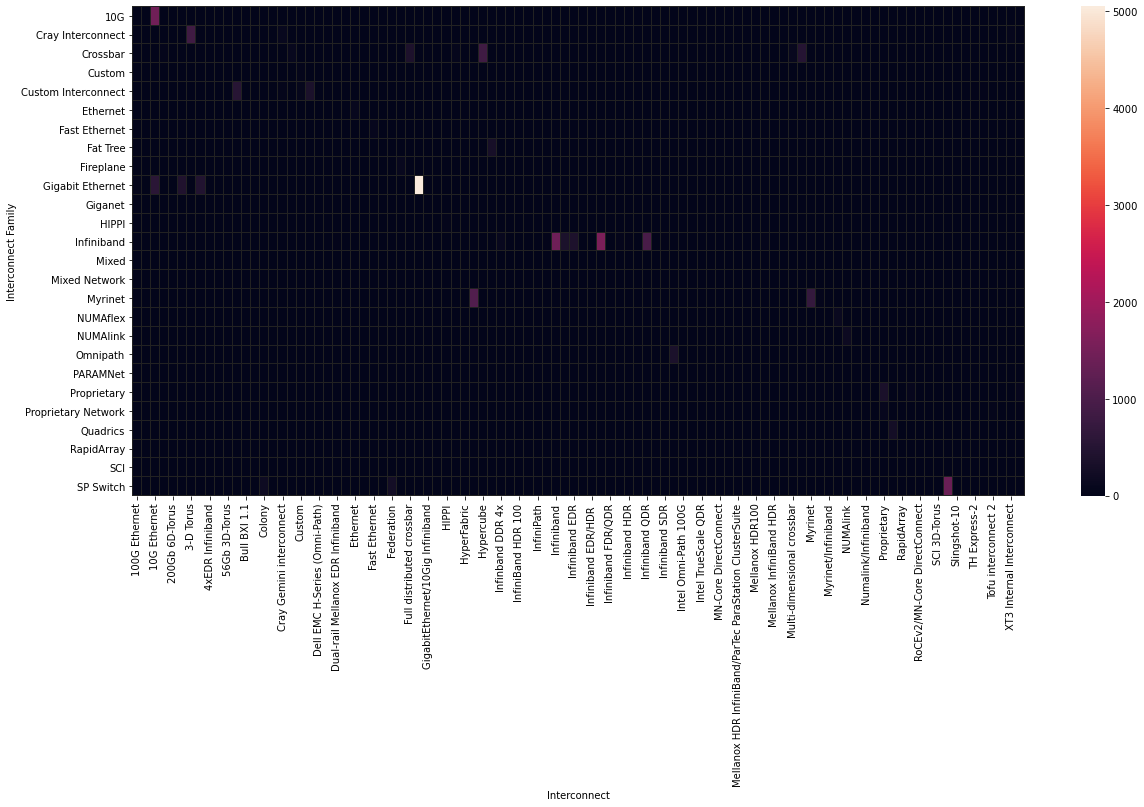

In [20]:
import seaborn as sns 

sns.heatmap(pd.crosstab(df["Interconnect Family"], df["Interconnect"]), linewidth=0.01, linecolor="#222")

# Save cleaned data

In [18]:
df.reset_index(inplace=True)
df = df[sorted(df.columns)]

In [19]:
df.to_csv("top500_clean.csv", index=False)